<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/master/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos

Dataset URL: https://www.kaggle.com/datasets/amanara/photos
License(s): unknown
 99% 271M/274M [00:04<00:00, 62.4MB/s]
100% 274M/274M [00:04<00:00, 58.4MB/s]


In [3]:
!unzip photos.zip;

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1252).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1253).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1254).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1255).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1256).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1257).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (126).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1260).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1261).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1262).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Tr

# Data preparation

In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'

def load_training_dataset(category):
  TRAINING_DATA_FOLDER = os.path.join('Dataset', 'Training_Data', category)
  x_doc = os.path.join('Dataset', 'Training_Data', category, 'Masked_Train')
  x_imgs = _load_images_from_folder(x_doc, category, TRAIN)
  y_doc = os.path.join('Dataset', 'Training_Data', category, 'Unmasked_Train')
  y_imgs = _load_images_from_folder(y_doc, category, TRAIN)
  csv_file = pd.read_csv(os.path.join(TRAINING_DATA_FOLDER, 'masked_info.csv'))
  return x_imgs, y_imgs, csv_file

def _load_images_from_folder(folder, category, set_type):
    images = []
    for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
              id, format = _parse_filename(filename)
              images.append({'filename': filename, 'category': category, 'id': id, 'set_type': set_type, 'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'category', 'id', 'set_type', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern = r'.*\((\d+)\)\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


In [5]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']

# Data analyzing

In [6]:
category = categories[0]
_, y, csv = load_training_dataset(category)
x_size = y['image'].apply(lambda img: pd.Series({'rows':img.shape[0], 'cols': img.shape[1]})).groupby(['rows','cols']).size()
print(f"{category}\n---------------------------")
print("total size = ",y.shape[0])
print(x_size)

Cat
---------------------------
total size =  1750
rows  cols
256   256     1750
dtype: int64


From the shown, it can be seen that all the images are of size 256 x 256

In [7]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Cat-Train (1085).jpeg,67,6,41,152
1,1,Cat-Train (900).jpeg,86,23,105,165
2,2,Cat-Train (1759).jpeg,60,99,3,140
3,3,Cat-Train (969).jpeg,14,138,47,137
4,4,Cat-Train (1559).jpeg,106,95,41,158


In [8]:
img_size = [256, 256]
box_size = [50, 50]

def is_within_bounds(row, col):
  return row + box_size[0] <= img_size[0] and col + box_size[1] <= img_size[1]

In [9]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [10]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
0,0,Cat-Train (1085).jpeg,67,6,41,152,True,True
1,1,Cat-Train (900).jpeg,86,23,105,165,True,True
2,2,Cat-Train (1759).jpeg,60,99,3,140,True,True
3,3,Cat-Train (969).jpeg,14,138,47,137,True,True
4,4,Cat-Train (1559).jpeg,106,95,41,158,True,True


In [11]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [12]:
x_cp = y.copy(deep=True)

In [13]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_row'], csv_row['box1_col'], csv_row['box2_row'], csv_row['box2_col']
    mask = np.zeros(img_size)
    mask[row2:row2+box_size[0], col2:col2+box_size[1]] = 1
    #cv2.rectangle(mask, (row1, col1), (row1 + box_size[0], col1 + box_size[1]), (255, 255, 255), -1)
    #cv2.rectangle(mask, (row2, col2), (row2 + box_size[0], col2 + box_size[1]), (255, 255, 255), -1)
    #masked_image = cv2.bitwise_and(image, 255 - mask)
    img_cp = image.copy()
    img_cp[mask==1] = 0
    mask = mask[:, :, np.newaxis]
    rgbm_image = np.concatenate((img_cp, mask), axis=2).astype(np.int32)
    return rgbm_image

In [14]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], box_size), axis = 1)

In [15]:
type(x_cp.iloc[0]['image'])

numpy.ndarray

In [16]:
merged_data = pd.merge(x_cp, csv, on='filename')
merged_data = pd.merge(merged_data, y, on = 'filename')

In [17]:
final_table_columns = ['filename', 'image_x', 'image_y', 'box2_row', 'box2_col']
train_df = merged_data.drop(columns=[col for col in merged_data if col not in final_table_columns])

In [18]:
#train_df.head()

In [19]:
test_row = train_df.iloc[3]
x_coord, y_coord = test_row['box2_row'], test_row['box2_col']
print(x_coord, y_coord)

11 55


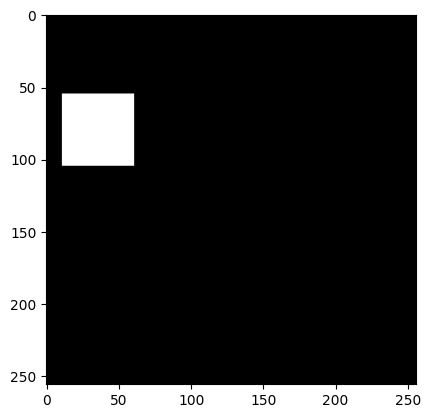

In [20]:
plt.imshow(test_row['image_x'][:,:,3], cmap='gray')
plt.show()

In [21]:
def crop_box(rgbm, y_img):
  mask = rgbm[:,:,3]
  rows, cols = np.where(mask == 1)

  min_row, max_row = np.min(rows), np.max(rows)
  min_col, max_col = np.min(cols), np.max(cols)

  return y_img[min_row:max_row + 1, min_col:max_col + 1, :]


In [22]:
train_df['image_y'] = train_df.apply(lambda row: crop_box(row['image_x'], row['image_y']), axis = 1)

array([[[212, 230, 231],
        [210, 222, 226],
        [186, 199, 201],
        ...,
        [ 94,  65,  38],
        [ 93,  64,  37],
        [ 93,  63,  38]],

       [[208, 225, 228],
        [215, 231, 237],
        [183, 198, 201],
        ...,
        [ 94,  65,  38],
        [ 91,  64,  38],
        [ 93,  63,  38]],

       [[209, 225, 231],
        [200, 216, 223],
        [200, 216, 222],
        ...,
        [ 92,  64,  40],
        [ 90,  64,  40],
        [ 92,  64,  40]],

       ...,

       [[164, 164, 180],
        [163, 166, 181],
        [165, 168, 183],
        ...,
        [200, 214, 226],
        [203, 217, 229],
        [207, 221, 233]],

       [[163, 163, 179],
        [162, 165, 180],
        [164, 167, 182],
        ...,
        [205, 219, 231],
        [208, 222, 234],
        [211, 225, 237]],

       [[162, 162, 178],
        [163, 163, 179],
        [165, 165, 181],
        ...,
        [207, 221, 233],
        [209, 223, 235],
        [211, 225, 237]]], dtype=uint8)
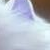

In [23]:
train_df.iloc[1]['image_y']

# Networks

In [24]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras.models import Sequential

## CNN

In [25]:
euclidean_model_1 = Sequential()

euclidean_model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(256, 256, 4)))
for i in range(9):
  if (i + 1) % 3 == 0:
     euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

euclidean_model_1.add(Flatten())
euclidean_model_1.add(Dense(50*50*3, activation='relu'))
euclidean_model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [26]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

def lr_schedule(epoch):
  model = euclidean_model_1 #change before model fit
  lr = K.get_value(model.optimizer.lr)
  if epoch % 2 == 0 and epoch > 0:
      K.set_value(model.optimizer.lr, lr * 0.8)
      print(f"Learning rate reduced to: {lr * 0.8}")
  return K.get_value(model.optimizer.lr)

batch_size = 64
weight_decay = 0.005
lr_scheduler = LearningRateScheduler(lr_schedule)

In [27]:
#train_df.iloc[0]['image_x']

In [28]:
print(type(train_df.iloc[0]['image_y']))
print(train_df.iloc[0]['image_y'].shape)

<class 'numpy.ndarray'>
(50, 50, 3)


In [29]:
#train_eucl_in =  np.asarray(train_df['image_x'])
#train_eucl_out = np.asarray(train_df['image_y'])
#train_eucl_out = np.reshape(train_eucl_out, (train_eucl_out.shape[0], 16875))

In [30]:
lr_scheduler = LearningRateScheduler(lr_schedule)
batch_size = 64
epochs = 50

In [31]:
X_train = np.stack(train_df['image_x'].values)
y_train = np.stack(train_df['image_y'].values)
y_train = y_train.reshape(y_train.shape[0],7500)

In [ ]:
history = euclidean_model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler],
    validation_split=0.2  # postotak podataka za validaciju
)



Epoch 1/50
